In [1]:
import distl
import numpy as np

[DistributionCollections](../api/DistributionCollection.md) allow for sampling (and computing probabilities) on multiple distributions simultaneously, respecting any covariances between the distributions within that set.

# "Simple Case" (Univariate only)

Let's first look at the simplest case possible with two univariate distributions.  As these will be drawn independently, there is little gained by using a [DistributionCollection](../api/DistributionCollection.md) over simply handling the two objects separately, but this example shows the syntax without having to deal with complex subtle points.

In [2]:
g = distl.gaussian(10, 2, label='gaussian')
u = distl.uniform(0, 5, label='uniform')

In [3]:
dc = distl.DistributionCollection(g, u)

In [4]:
dc

When calling [sample](../api/DistributionCollection.sample.md), values are returned for each distribution in the order they were passed when initializing the object.

In [5]:
dc.sample()

array([7.94423774, 3.38192392])

If ever unsure, we can access the underlying distribution objects via the [distributions](../api/DistributionCollection.distributions.md) or [labels](../api/DistributionCollection.labels.md) properties.

In [6]:
dc.distributions

[<distl.gaussian loc=10.0 scale=2.0 label=gaussian>,
 <distl.uniform low=0.0 high=5.0 label=uniform>]

In [7]:
dc.labels

['gaussian', 'uniform']

If passing `size` to [sample](../api/DistributionCollection.sample.md), we get a matrix with shape (`size`, `len(distributions)`)

In [8]:
dc.sample(size=3)

array([[13.05648357,  3.17603292],
       [ 7.23378384,  3.35741225],
       [10.18171253,  2.41334386]])

We can also call [plot](../api/DistributionCollection.plot.md) or [plot_sample](../api/DistributionCollection.plot_sample.md).  Here we're shown a corner plot and see that the samples were drawn independently (without any covariances).

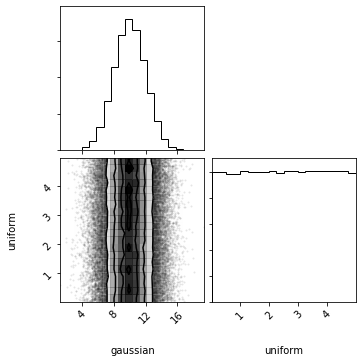

In [9]:
out = dc.plot(show=True)

Additionally, we can access [pdf](../api/DistributionCollection.pdf.md), [logpdf](../api/DistributionCollection.logpdf.md), [cdf](../api/DistributionCollection.cdf.md), and [logcdf](../api/DistributionCollection.logcdf.md). These all take a single argument which must be a list/tuple/array with the same length as the number of distributions.

In the case of univariate distributions, pdf and cdf will be simply the product of the values from the children distributions, and logpdf and logcdf the sums.  However, this is where subtle complications come into place with [Composite](../api/Composite.md) and Multivariate distributions, which we'll see in the next few sections.

In [10]:
dc.pdf([10, 5])

0.039894228040143274

In [11]:
g.pdf(10) * u.pdf(5)

0.039894228040143274

# using MultivariateSlice distributions

First we'll create a [gaussian](../api/distl.gaussian.md), [uniform](../api/distl.uniform.md), and [multivariate gaussian](../api/distl.mvgaussian.md) distributions.

In [12]:
g = distl.gaussian(10, 2, label='gaussian')
u = distl.uniform(0, 5, label='uniform')
mvg = distl.mvgaussian([5,10, 12], 
                       np.array([[ 2,  1, -1], 
                                 [ 1,  2,  1], 
                                 [-1,  1,  2]]),
                       allow_singular=True,
                       labels=['mvg_a', 'mvg_b', 'mvg_c'])

Now let's imagine a scenario where we want to draw from the following sub-distributions: 'gaussian', 'uniform', 'mvg_a', and 'mvg_c' (but let's say we don't want 'mvg_b').  Here we want to *maintain* the covariances between 'mvg_a' and 'mvg_c' while *independently* sampling from 'gaussian' and 'uniform'.

Yes, in theory you could call sample on `g`, `u`, `mvg` and just ignore the second index in the returned arrays from `mvg.sample`... but a [DistributionCollection](../api/DistributionCollection.md) starts to provide some convenience in this case for both plotting and accessing the probabilities of a given drawn sample.  This becomes especially useful when coupled with [sample caching](./sample_cache.ipynb).

To learn more about slicing multivariate distributions, see [multivariate slicing](./multivariate_slice.ipynb), but in simple terms it allows you to select a single dimension from a multivariate distribution, acting like a univariate distribution but still retaining the underlying covariances of the multivariate distribution.

In [13]:
dc = distl.DistributionCollection(g, u, mvg.slice('mvg_a'), mvg.slice('mvg_c'))

In [14]:
dc.sample()

array([11.26488164,  0.87127455,  5.54918169, 12.94481664])

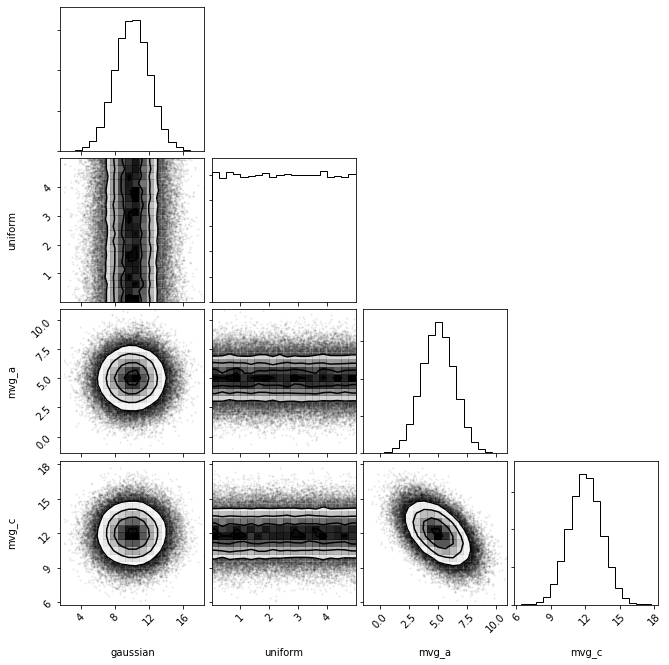

In [15]:
out = dc.plot(show=True)

As in the univariate case, [pdf](../api/DistributionCollection.pdf.md) takes a tuple/list/array with the same length as the provided number of distributions (and in the same order as [labels](../api/DistributionCollection.labels.md).

It is **very** important to note here that this call to pdf does **NOT** account for the covariance between 'mvg_a' and 'mvg_c' (as it would also be necessary to know the assumed value of mvg_b or to collapse along that dimension).

In [16]:
dc.labels

['gaussian', 'uniform', 'mvg_a', 'mvg_c']

In [17]:
dc.pdf([10, 5, 5, 11])

0.0024724446692818785

**TODO**: need to support and explain three cases
* treat each as univariates for pdf (DONE)
* collapse the unused dimensions out and calculate multivariate pdf (NEED TO IMPLEMENT - can probably detect based on the length passed to `pdf` but could also have a different method or flag to be explicit).  At the least, we need to think about the default behavior when caching the samples
* provide unsampled value and calculate multivariate pdf (or maybe three is too much and we should drop this one)

# using Composite distributions

Now let's consider a more complex example: let's sample from 'gaussian * mvg_a' and 'mvg_c'.  Here we want the covariance between 'mvg_a' and 'mvg_c' respected, even though there is a math operation on the result of 'mvg_a'.

In [19]:
# TODO: this won't work until math with multivariates is implemented
#dc = distl.DistributionCollection(g * mvg.slice('mvg_a'), mvg.slice('mvg_c'))

In [ ]:
#dc.sample()

In [ ]:
#dc.pdf()